# Computer Vision Project : Spatial Pyramid Pooling for Vehicle Detection

Raktim Dey (MDS202132) \
Rishika Tibrewal (MDS202135) \
Shreyansh Rastogi (MDS202144)




## Importing Libraries

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.8 MB/s eta 0:00:00


In [ ]:
import scipy.io
import cv2, PIL
import numpy as np 
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import warnings,random
warnings.filterwarnings('ignore')

In [ ]:
import keras
from keras import Model
from keras import optimizers
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow_addons.layers import SpatialPyramidPooling2D

## Downloading Dataset

In [ ]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_test.tgz

--2023-04-17 13:47:58--  http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  18.7MB/s    in 56s     

2023-04-17 13:48:54 (16.6 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [ ]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat

--2023-04-17 13:48:55--  http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘cars_test_annos_withlabels.mat’

cars_test_annos_wit 100%[===================>] 181.40K   171KB/s    in 1.1s    

2023-04-17 13:48:56 (171 KB/s) - ‘cars_test_annos_withlabels.mat’ saved [185758/185758]



In [ ]:
!tar -xvf cars_test.tgz

Streaming output truncated to the last 5000 lines.
cars_test/03042.jpg
cars_test/03043.jpg
cars_test/03044.jpg
cars_test/03045.jpg
cars_test/03046.jpg
cars_test/03047.jpg
cars_test/03048.jpg
cars_test/03049.jpg
cars_test/03050.jpg
cars_test/03051.jpg
cars_test/03052.jpg
cars_test/03053.jpg
cars_test/03054.jpg
cars_test/03055.jpg
cars_test/03056.jpg
cars_test/03057.jpg
cars_test/03058.jpg
cars_test/03059.jpg
cars_test/03060.jpg
cars_test/03061.jpg
cars_test/03062.jpg
cars_test/03063.jpg
cars_test/03064.jpg
cars_test/03065.jpg
cars_test/03066.jpg
cars_test/03067.jpg
cars_test/03068.jpg
cars_test/03069.jpg
cars_test/03070.jpg
cars_test/03071.jpg
cars_test/03072.jpg
cars_test/03073.jpg
cars_test/03074.jpg
cars_test/03075.jpg
cars_test/03076.jpg
cars_test/03077.jpg
cars_test/03078.jpg
cars_test/03079.jpg
cars_test/03080.jpg
cars_test/03081.jpg
cars_test/03082.jpg
cars_test/03083.jpg
cars_test/03084.jpg
cars_test/03085.jpg
cars_test/03086.jpg
cars_test/03087.jpg
cars_test/03088.jpg
cars_test

## Loading Dataset

In [ ]:
mat = scipy.io.loadmat('/content/cars_test_annos_withlabels.mat')

The first four values are the co-ordinates of the bounding box. I'm not sure what the fifth one is.

In [ ]:
bounding_box=dict()
bounding_box["x1"],bounding_box["y1"],bounding_box["x2"],bounding_box["y2"],bounding_box["unknowns"],bounding_box["names"]=[],[],[],[],[],[]
for vals in mat["annotations"][0]:
  x1,y1,x2,y2,unknown,name=vals[0].item(),vals[1].item(),vals[2].item(),vals[3].item(),vals[4].item(),vals[5].item()
  bounding_box["names"].append(name)
  bounding_box["x1"].append(x1)
  bounding_box["y1"].append(y1)
  bounding_box["x2"].append(x2)
  bounding_box["y2"].append(y2)
  bounding_box["unknowns"].append(unknown)

In [ ]:
bounding_box=pd.DataFrame(bounding_box)

In [ ]:
bounding_box.head()

,x1,y1,x2,y2,unknowns,names
0,30,52,246,147,181,00001.jpg
1,100,19,576,203,103,00002.jpg
2,51,105,968,659,145,00003.jpg
3,67,84,581,407,187,00004.jpg
4,140,151,593,339,185,00005.jpg


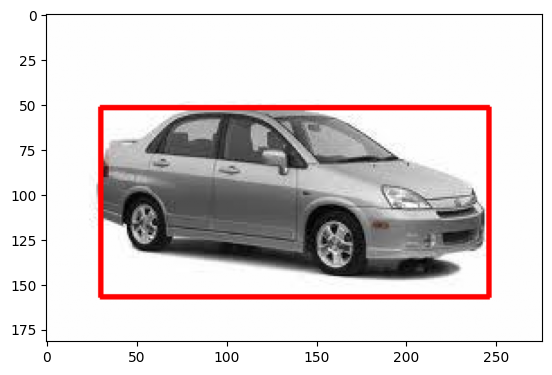

In [ ]:
img=cv2.imread("/content/cars_test/00001.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=img.astype("float")/255.0
img = cv2.rectangle(img, (30,52), (246,157), (255,0,0), 2)
plt.imshow(img)

In [ ]:
train_path="/content/cars_test/"

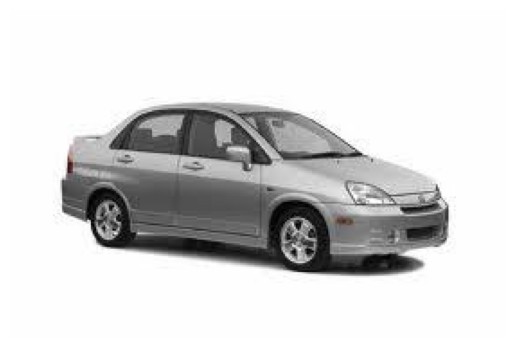

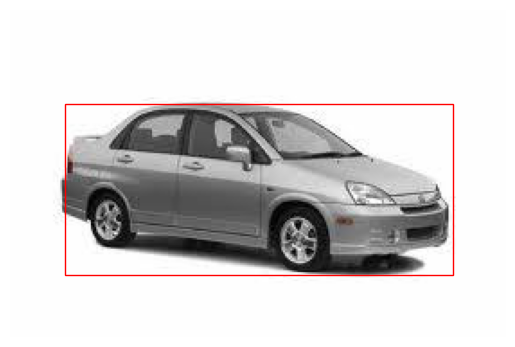

In [ ]:
def display_image(path, box=None, specific=False):  
#     print(int(box['xmin']), int(box['ymin']), int(box['xmax']-box['xmin']), int(box['ymax']-box['ymin']))
    if not specific:
        plt.imshow(Image.open(path))
        plt.axis('off')
        img = Image.open(path)
        fig, ax = plt.subplots()
        ax.imshow(img)
        plt.axis('off')
        rect = patches.Rectangle((int(box['x1']), int(box['y1'])), int(box['x2']-box['x1']), int(box['y2']-box['y1']), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()
    else:
        plt.imshow(path)
        plt.axis('off')
        fig, ax = plt.subplots()
        ax.imshow(path)
        plt.axis('off')
        for i in box:
            rect = patches.Rectangle((int(i[0]-(i[2]/2)), int(i[1]-(i[3]/2))), int(i[2]), int(i[3]), linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()
display_image(train_path + '/' + bounding_box['names'][0], bounding_box[0:1])


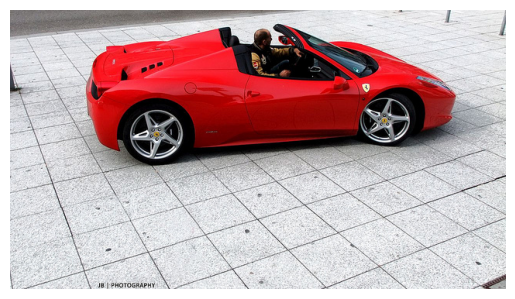

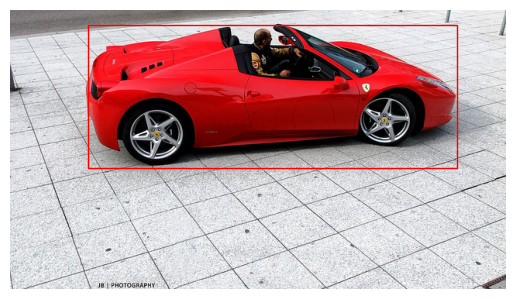

In [ ]:
display_image(train_path + '/' + bounding_box['names'][1], bounding_box[1:2])

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
train_images = []
train_labels = []

In [ ]:
for i in range(200):
    image = cv2.imread(train_path + '/' + bounding_box['names'][i])
#         image = np.array(Image.open(train_path + '/' + labels['image'][i]))
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    print(f'[{i}] {bounding_box["names"][i]} {ssresults.shape}')
#         imout = image.copy()
    counter = 0
    falsecounter = 0
    flag = 0
    fflag = 0
    bflag = 0
    gtval = {"x1":bounding_box.iloc[i]['x1'].item(),"x2":bounding_box.iloc[i]['x2'].item(),"y1":bounding_box.iloc[i]['y1'].item(),"y2":bounding_box.iloc[i]['y2'].item()}
    for e, result in enumerate(ssresults):
        if e < 2000 and flag == 0:
            x,y,w,h = result
            iou = get_iou(gtval, {"x1":x,"x2":x+w,"y1":y,"y2":y+h})
            if counter < 7:
                if iou > 0.50:
                    timage = image[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(1)
                    counter += 1
            else:
                fflag = 1
            if falsecounter < 5:
                if iou < 0.3:
                    timage = image[y:y+h,x:x+w]
                    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                    train_images.append(resized)
                    train_labels.append(0)
                    falsecounter += 1
            else:
                bflag = 1
            if fflag == 1 and bflag == 1:
#                     print("inside")
                flag = 1

    print(f'train_images: {len(train_images)}, 1: {counter}, 0: {falsecounter}')

[0] 00001.jpg (244, 4)
train_images: 12, 1: 7, 0: 5
[1] 00002.jpg (2110, 4)
train_images: 24, 1: 7, 0: 5
[2] 00003.jpg (5818, 4)
train_images: 32, 1: 3, 0: 5
[3] 00004.jpg (2226, 4)
train_images: 44, 1: 7, 0: 5
[4] 00005.jpg (2088, 4)
train_images: 56, 1: 7, 0: 5
[5] 00006.jpg (855, 4)
train_images: 68, 1: 7, 0: 5
[6] 00007.jpg (23316, 4)
train_images: 75, 1: 2, 0: 5
[7] 00008.jpg (6048, 4)
train_images: 85, 1: 5, 0: 5
[8] 00009.jpg (914, 4)
train_images: 97, 1: 7, 0: 5
[9] 00010.jpg (803, 4)
train_images: 109, 1: 7, 0: 5
[10] 00011.jpg (1239, 4)
train_images: 121, 1: 7, 0: 5
[11] 00012.jpg (696, 4)
train_images: 133, 1: 7, 0: 5
[12] 00013.jpg (1362, 4)
train_images: 145, 1: 7, 0: 5
[13] 00014.jpg (1142, 4)
train_images: 157, 1: 7, 0: 5
[14] 00015.jpg (2274, 4)
train_images: 169, 1: 7, 0: 5
[15] 00016.jpg (479, 4)
train_images: 181, 1: 7, 0: 5
[16] 00017.jpg (1964, 4)
train_images: 193, 1: 7, 0: 5
[17] 00018.jpg (2268, 4)
train_images: 205, 1: 7, 0: 5
[18] 00019.jpg (714, 4)
train_imag

## Splitting Dataset into Train Test

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

## Building Models for Vehicle Detection

### Building a Convolutional Neural Network without SPP Layer

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(512, (5,5), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(512, (5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(256, (5,5), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return model

In [ ]:
model=create_model()
opt = Adam(learning_rate=0.0001)
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 512)     38912     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 512)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 512)     6554112   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 256)       3277056   
                                                                 
 flatten (Flatten)           (None, 614656)            0

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

#checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
hist = model.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 50, validation_data= testdata, validation_steps=2)

Epoch 1/50
10/10 [==============================] - 81s 1s/step - loss: 101.8270 - accuracy: 0.5219 - val_loss: 6.8310 - val_accuracy: 0.5312
Epoch 2/50
10/10 [==============================] - 10s 950ms/step - loss: 2.1948 - accuracy: 0.5656 - val_loss: 0.6683 - val_accuracy: 0.6562
Epoch 3/50
10/10 [==============================] - 10s 922ms/step - loss: 0.6431 - accuracy: 0.5594 - val_loss: 0.6487 - val_accuracy: 0.6562
Epoch 4/50
10/10 [==============================] - 9s 905ms/step - loss: 0.6766 - accuracy: 0.6906 - val_loss: 4.0141 - val_accuracy: 0.5469
Epoch 5/50
10/10 [==============================] - 9s 910ms/step - loss: 0.9631 - accuracy: 0.6594 - val_loss: 0.6384 - val_accuracy: 0.5938
Epoch 6/50
10/10 [==============================] - 75s 964ms/step - loss: 0.6737 - accuracy: 0.5956 - val_loss: 0.7238 - val_accuracy: 0.5156
Epoch 7/50
10/10 [==============================] - 10s 958ms/step - loss: 0.6756 - accuracy: 0.5938 - val_loss: 0.6277 - val_accuracy: 0.7344
Ep

In [ ]:
model.save("CNN without SPP.h5")

#### Test

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)



### Building a Convolutional Neural Network with SPP Layer

<b>Single-size Training</b>

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(512, (5,5), activation='relu', input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(512, (5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(256, (5,5), activation='relu'),
        SpatialPyramidPooling2D((1,2,4)),
        Flatten(),
        Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    return model

In [ ]:
model=create_model()
opt = Adam(learning_rate=0.0001)
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 220, 220, 512)     38912     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 512)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 106, 106, 512)     6554112   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 512)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 49, 49, 256)       3277056   
                                                                 
 spatial_pyramid_pooling2d (  (None, 21, 256)         

In [ ]:
model.save("CNN with SPP.h5")

In [ ]:
hist_spp = model.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 50, validation_data= testdata, validation_steps=2)

Epoch 1/50
10/10 [==============================] - 11s 1s/step - loss: 10.0696 - accuracy: 0.4719 - val_loss: 2.5742 - val_accuracy: 0.5625
Epoch 2/50
10/10 [==============================] - 11s 1s/step - loss: 2.9720 - accuracy: 0.5250 - val_loss: 0.7164 - val_accuracy: 0.6562
Epoch 3/50
10/10 [==============================] - 10s 1s/step - loss: 1.1722 - accuracy: 0.6531 - val_loss: 0.7113 - val_accuracy: 0.6562
Epoch 4/50
10/10 [==============================] - 10s 961ms/step - loss: 0.6630 - accuracy: 0.7125 - val_loss: 0.5098 - val_accuracy: 0.7656
Epoch 5/50
10/10 [==============================] - 10s 999ms/step - loss: 0.5527 - accuracy: 0.7688 - val_loss: 0.4951 - val_accuracy: 0.7969
Epoch 6/50
10/10 [==============================] - 10s 980ms/step - loss: 0.4773 - accuracy: 0.8031 - val_loss: 0.4444 - val_accuracy: 0.8125
Epoch 7/50
10/10 [==============================] - 11s 1s/step - loss: 0.3520 - accuracy: 0.8344 - val_loss: 0.5003 - val_accuracy: 0.7188
Epoch 8/50

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
# trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
# traindata = trdata.flow(x=X_train, y=y_train)
# tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
# testdata = tsdata.flow(x=X_test, y=y_test)

model=create_model()
opt = Adam(learning_rate=0.0001)
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model.summary()

# Define the input sizes
input_sizes = [180, 224, 288]

# Create the data generators


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 512)     38912     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 512)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 512)     6554112   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 256)       3277056   
                                                                 
 spatial_pyramid_pooling2d (  (None, 21, 256)          0

<b>Multi-size Training</b>

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
data_generators = []
for size in input_sizes:
    traindata = trdata.flow(x=X_train, y=y_train)
    testdata = tsdata.flow(x=X_test, y=y_test)
    data_generators.append([traindata,testdata])

# Train the model
for i, size in enumerate(input_sizes):
    print('Training with input size: ', size)
    train,test = data_generators[i]
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(generator= train, steps_per_epoch= 10, epochs= 50, validation_data= test, validation_steps=2)

Training with input size:  180
Epoch 1/50
10/10 [==============================] - 88s 1s/step - loss: 121.0848 - accuracy: 0.5344 - val_loss: 0.5922 - val_accuracy: 0.6719
Epoch 2/50
10/10 [==============================] - 10s 909ms/step - loss: 0.7437 - accuracy: 0.5531 - val_loss: 0.6990 - val_accuracy: 0.4375
Epoch 3/50
10/10 [==============================] - 9s 937ms/step - loss: 0.6901 - accuracy: 0.6875 - val_loss: 0.5610 - val_accuracy: 0.6875
Epoch 4/50
10/10 [==============================] - 10s 946ms/step - loss: 0.5817 - accuracy: 0.7250 - val_loss: 0.5755 - val_accuracy: 0.8438
Epoch 5/50
10/10 [==============================] - 11s 1s/step - loss: 0.5377 - accuracy: 0.8188 - val_loss: 1.2912 - val_accuracy: 0.6562
Epoch 6/50
10/10 [==============================] - 10s 934ms/step - loss: 0.4894 - accuracy: 0.8594 - val_loss: 0.6129 - val_accuracy: 0.7344
Epoch 7/50
10/10 [==============================] - 10s 945ms/step - loss: 0.3232 - accuracy: 0.8844 - val_loss: 0.3

## Comparison of metrics of CNN without and with SPP Layer

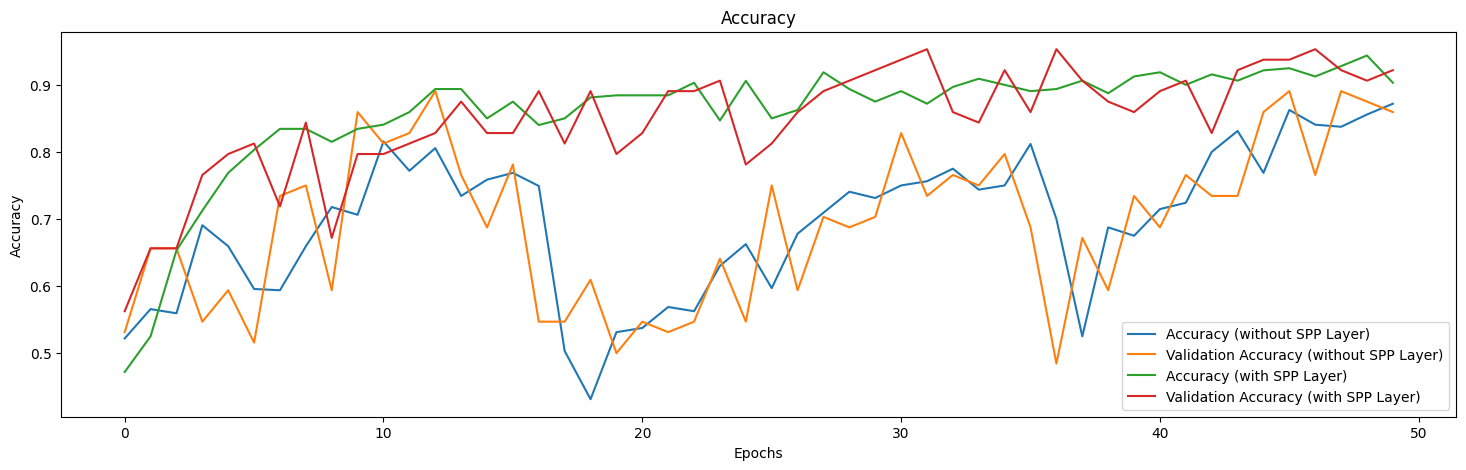

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(hist.history["accuracy"],label="Accuracy (without SPP Layer)")
plt.plot(hist.history["val_accuracy"],label="Validation Accuracy (without SPP Layer)")
plt.plot(hist_spp.history["accuracy"],label="Accuracy (with SPP Layer)")
plt.plot(hist_spp.history["val_accuracy"],label="Validation Accuracy (with SPP Layer)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.title("Accuracy")
plt.show()

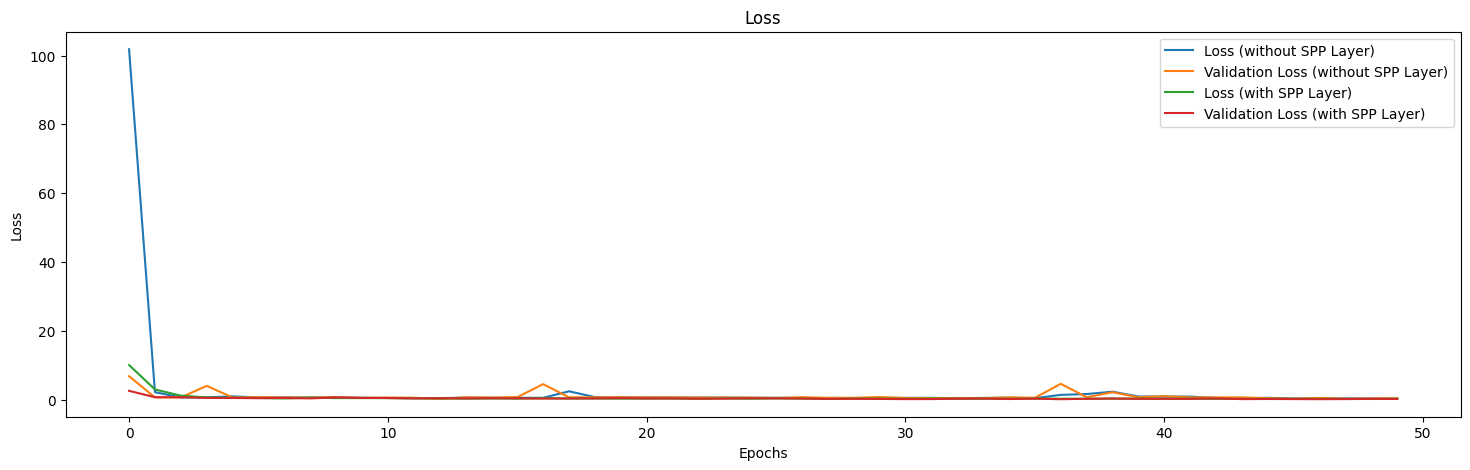

In [ ]:
plt.figure(figsize=(18,5))
plt.plot(hist.history["loss"],label="Loss (without SPP Layer)")
plt.plot(hist.history["val_loss"],label="Validation Loss (without SPP Layer)")
plt.plot(hist_spp.history["loss"],label="Loss (with SPP Layer)")
plt.plot(hist_spp.history["val_loss"],label="Validation Loss (with SPP Layer)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.title("Loss")
plt.show()

## Checking performance of both the models on test data

In [ ]:
model_SPP = keras.models.load_model('/content/CNN with SPP.h5')

In [ ]:
model = keras.models.load_model('/content/CNN without SPP.h5')

1/1 [==============================] - 0s 20ms/step
Car


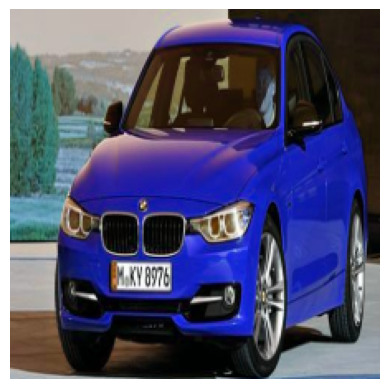

In [ ]:
im = X_test[random.randint(0,200)]
plt.imshow(im)
plt.axis('off')
img = np.expand_dims(im, axis=0)
out= model_SPP.predict(img)
if out[0][0] > out[0][1]:
    print("Car")
else:
    print("not Car")

1/1 [==============================] - 0s 20ms/step
not Car


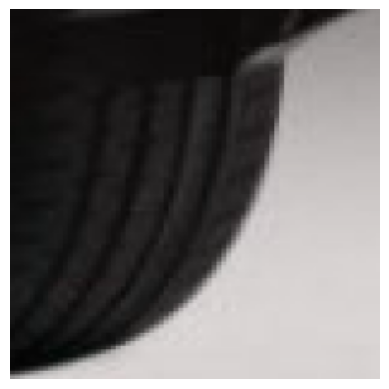

In [ ]:
im = X_test[random.randint(0,200)]
plt.imshow(im)
plt.axis('off')
img = np.expand_dims(im, axis=0)
out= model_SPP.predict(img)
if out[0][0] > out[0][1]:
    print("Car")
else:
    print("not Car")

1/1 [==============================] - 0s 32ms/step


Text(0.5, 1.0, 'With SPP: not Car Without SPP: not Car True Label: not Car')

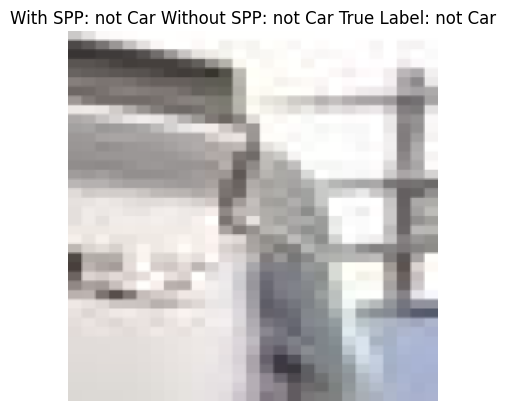

In [ ]:
ind = 16
im = X_test[ind]
lab = y_test[ind]

img = np.expand_dims(im, axis=0)
out= model.predict(img)
out_SPP = model_SPP.predict(img)
if out_SPP[0][0] > out_SPP[0][1]:
    a = "With SPP: Car "
else:
    a = "With SPP: not Car "
if out[0][0] > out[0][1]:
    b = "Without SPP: Car "
else:
    b = "Without SPP: not Car "
if lab[0] > lab[1]:
    c = "True label: Car"
else:
    c = "True Label: not Car"

plt.imshow(im)
plt.axis('off')
plt.title(a+b+c)